# Lale's Batching operator

The `lale.lib.lale.Batching` operator allows batch-wise fit of a lale pipeline.
It uses the `partial_fit` method from the pipeline's operators. See also the
[API documentation](https://lale.readthedocs.io/en/latest/modules/lale.lib.lale.batching.html).

### Dataset

This demonstration uses a synthetic dataset created using scikit-learn's `make_classification`.

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
import pandas as pd
import numpy as np

n_samples = 2000
n_features = 70
n_classes = 2
test_size = 0.2

X, y = make_classification(n_samples=n_samples, n_features=n_features, n_informative=n_features,
                           n_redundant=0, n_classes=n_classes, random_state=42,
                           n_clusters_per_class=1, flip_y=0.01, shuffle=False)
y = y.reshape(-1, 1)
df1 = pd.DataFrame(data=X)
df2 = pd.DataFrame(data=y)
df = pd.concat([df1, df2], axis=1)
df.columns = range(len(df.columns))
train, test = train_test_split(df, test_size=test_size)
train_X = train.iloc[:,:-1]
train_y = train.iloc[:,-1]
test_X = test.iloc[:,:-1]
test_y = test.iloc[:,-1]

`Batching` is a higher order operator that takes a pipeline as its parameter. The assumption is that the operators in the pipeline are either already trained and frozen or support partial_fit.

### Case 1: 

All the operators support `partial_fit` and we want to train such a pipeline batch-wise.

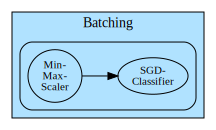

In [2]:
from lale.lib.lale import Batching
from lale.lib.sklearn import MinMaxScaler, SGDClassifier

pipeline = Batching(operator=MinMaxScaler() >> SGDClassifier())
pipeline.visualize()

In [3]:
#pandas dataframe does not work through the entire pipeline because MinMaxScaler outputs numpy array.
trained_pipeline = pipeline.fit(train_X.values, train_y.values)

In [4]:
predictions = trained_pipeline.predict(test_X.values)

In [5]:
from sklearn.metrics import accuracy_score

accuracy_score(test_y, predictions)

0.9075

### Case 2:

All the operators except the estimator are trained and frozen, so we only need to train the estimator which supports `partial_fit`. For this example, we will use a pre-trained pipeline using IBM AutoAI and try to modify the pipeline by just changing the estimator node. We can train such a pipeline using `Batching` as shown in this section.

In [6]:
import joblib
import os
import urllib.request

pickled_model_path = os.path.join(
    "..",
    "lale",
    "datasets",
    "autoai",
    "credit_risk.pickle",
)
pipeline = joblib.load(pickled_model_path)

train_csv_path = "german_credit_data_biased_training.csv"
train_csv_url = "https://raw.githubusercontent.com/pmservice/wml-sample-models/master/autoai/credit-risk-prediction/data/german_credit_data_biased_training.csv"

urllib.request.urlretrieve(train_csv_url, train_csv_path)
training_df = pd.read_csv(
    train_csv_path
)

train, test = train_test_split(training_df, test_size=test_size)
train_X = train.iloc[:,:-1]
train_y = train.iloc[:,-1]
test_X = test.iloc[:,:-1]
test_y = test.iloc[:,-1]

/Users/kakateus.ibm.com/venv/lale39/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator SimpleImputer from version 0.23.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/kakateus.ibm.com/venv/lale39/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator OrdinalEncoder from version 0.23.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/kakateus.ibm.com/venv/lale39/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.23.1 when using version 

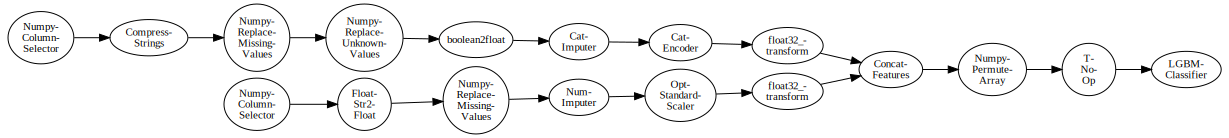

In [7]:
pipeline.visualize()

In [8]:
new_pipeline = pipeline.remove_last().freeze_trained() >> SGDClassifier()

In [9]:
batched_pipeline = Batching(operator=new_pipeline, batch_size=1024)

In [10]:
#As the pickle was created for sklearn<1.0
import sklearn
if sklearn.__version__ < "1.0":
    trained_batched_pipeline = batched_pipeline.fit(train_X.values, train_y.values)
    predictions = trained_batched_pipeline.predict(test_X.values)
    from sklearn.metrics import accuracy_score
    accuracy_score(test_y, predictions)

### Case 3:

Orthogonal to the first two cases, but this is to show that we can also pass an external `torch.util.data.Dataset` class to the `fit` method of a Batching operator. This allows for custom data formats as well as data reading mechanisms to be incorporated. For demonstrating this, we use the `NumpyTorchDataset` from `lale.util` and the dataset and pipeline from the example in Case 2.

In [11]:
from lale.util.numpy_to_torch_dataset import NumpyTorchDataset

def numpy_collate_fn(batch):
    return_X = None
    return_y = None
    for item in batch:
        if isinstance(item, tuple):
            if return_X is None:
                return_X = item[0]
            else:
                return_X = np.vstack((return_X, item[0]))
            if return_y is None:
                return_y = item[1]
            else:
                return_y = np.vstack((return_y, item[1]))
        else:
            if return_X is None:
                return_X = item
            else:
                return_X = np.vstack((return_X, item))
    if return_y is not None:
        if len(return_y.shape) > 1 and return_y.shape[1] == 1:
            return_y = np.reshape(return_y, (len(return_y),))
        return return_X, return_y
    else:
        return return_X

X = dict({"dataset": NumpyTorchDataset(train_X.values, train_y.values), "collate_fn": numpy_collate_fn})

In [12]:
if sklearn.__version__ < "1.0":
    trained_batched_pipeline = batched_pipeline.fit(X, classes=['No Risk', 'Risk'])
    test_X = {"dataset": NumpyTorchDataset(test_X.values), "collate_fn": numpy_collate_fn}
    predictions = trained_batched_pipeline.predict(test_X)
    from sklearn.metrics import accuracy_score
    accuracy_score(test_y, predictions)

### Case 4:

This example uses operators from `lale.lib.rasl` so that the preprocessing as well as classification can be trained batch-wise, and potentially many of the tasks can run in parallel.

Also note that we pass a DataLoader to `Batching.fit`.

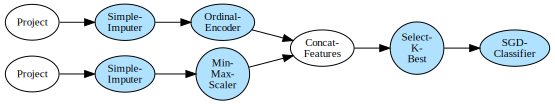

In [13]:
from lale.lib.rasl import SimpleImputer
from lale.lib.rasl import OrdinalEncoder
from lale.lib.rasl import MinMaxScaler
from lale.lib.rasl import SelectKBest
from lale.lib.lale import ConcatFeatures
from lale.lib.lale import Project, categorical
import lale.lib.rasl
import lale.datasets.openml

(train_X, train_y), (test_X, test_y) = lale.datasets.openml.fetch("credit-g", "classification", preprocess=False)

cat_columns = categorical(20)(train_X)
num_columns = list(set(train_X.columns)-set(cat_columns))

cat_prep = (Project(columns=cat_columns) >> SimpleImputer(strategy="constant") >>
    OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))

num_prep = (Project(columns=num_columns)
    >> SimpleImputer(strategy="mean")
    >> MinMaxScaler())

pipeline = (cat_prep & num_prep) >> ConcatFeatures() >> SelectKBest() >>  SGDClassifier()
pipeline.visualize()

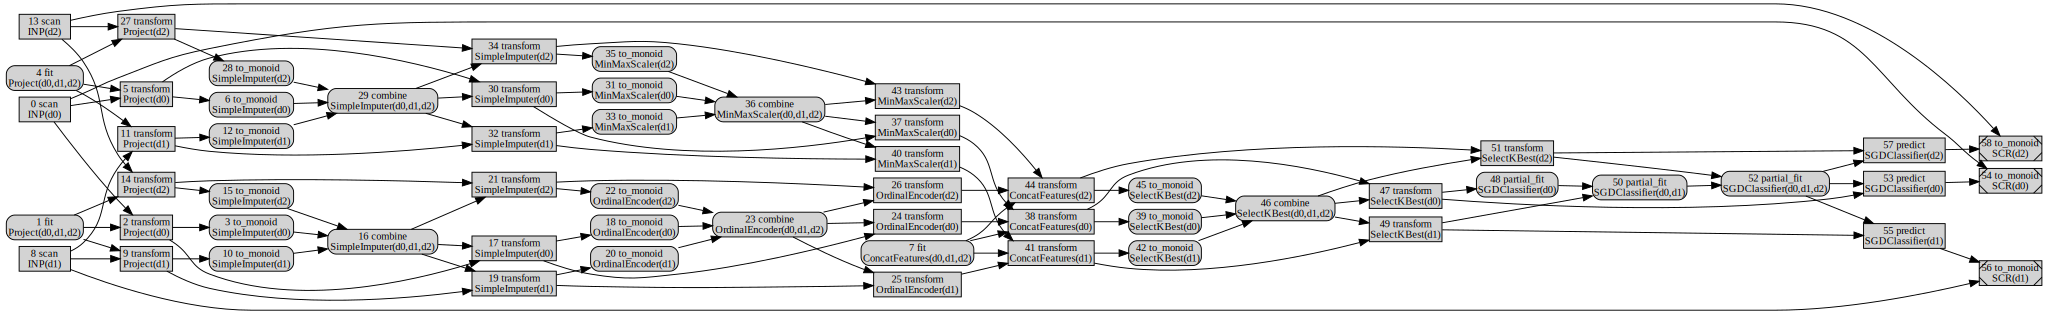

{
    "spill_count": 0,
    "load_count": 0,
    "spill_space": 0,
    "load_space": 0,
    "min_resident": 79872,
    "max_resident": 9223372036854775807,
    "train_count": 26,
    "apply_count": 30,
    "metric_count": 3,
    "train_time": 0.08338499069213867,
    "apply_time": 0.1755058765411377,
    "metric_time": 0.0039980411529541016,
    "critical_count": 17,
    "critical_time": 0.08906888961791992,
}


0.6303030303030303

In [14]:
accuracy_scorer = lale.lib.rasl.get_scorer("accuracy")

batched_pipeline = Batching(operator=pipeline, scoring=accuracy_scorer, progress_callback=None, verbose=2)

from lale.helpers import create_data_loader
X = create_data_loader(train_X, train_y, batch_size=224)

trained_batched_pipeline = batched_pipeline.fit(X, classes=['bad', 'good'])
predictions = trained_batched_pipeline.predict(test_X)
from sklearn.metrics import accuracy_score
accuracy_score(test_y, predictions)